This gives an example of the use of the Markov Switching Model that I wrote for the [Statsmodels](https://github.com/statsmodels/statsmodels) Python package, to replicate Hamilton's (1989) seminal paper introducing Markov-switching models via the Hamilton Filter. It uses the Kim (1994) smoother, and matches the treatment in Kim and Nelson (1999).

This is tested against Kim and Nelson's (1999) code (HMT4_KIM.OPT), which can be found at [http://econ.korea.ac.kr/~cjkim/SSMARKOV.htm](http://econ.korea.ac.kr/~cjkim/SSMARKOV.htm). It also corresponds to the examples of Markov-switching models from E-views 8, which can be found at [http://www.eviews.com/EViews8/ev8ecswitch_n.html#MarkovAR](http://www.eviews.com/EViews8/ev8ecswitch_n.html#MarkovAR).

<!-- TEASER_END -->

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.mar_model import MAR

In [2]:
# Model Setup
order = 4
nstates = 2

switch_ar = False
switch_sd = False
switch_mean = True

In [3]:
# Hamilton's 1989 GNP dataset: Quarterly, 1947.1 - 1995.3
f = open('data/gdp4795.prn')
data = pd.DataFrame(
    [float(line) for line in f.readlines()[:-3]],
    index=pd.date_range('1947-01-01', '1995-07-01', freq='QS'),
    columns=['gnp']
)
data['dlgnp'] = np.log(data['gnp']).diff()*100
data = data['1952-01-01':'1984-10-01']

# NBER recessions
from pandas.io.data import DataReader
from datetime import datetime
usrec = DataReader('USREC', 'fred', start=datetime(1947, 1, 1), end=datetime(2013, 4, 1))

In [4]:
mod = MAR(data.dlgnp, 4, nstates)
params = np.array([
    1.15590, -2.20657,
    0.08983, -0.01861, -0.17434, -0.08392,
    -np.log(0.79619),
    -0.21320, 1.12828
])

In [5]:
# Filter the data
(
    marginal_densities, filtered_joint_probabilities,
    filtered_joint_probabilities_t1
) = mod.filter(params);

transitions = mod.separate_params(params)[0]

# Smooth the data
filtered_marginal_probabilities = mod.marginalize_probabilities(filtered_joint_probabilities[1:])
smoothed_marginal_probabilities = mod.smooth(filtered_joint_probabilities, filtered_joint_probabilities_t1, transitions)

# Save the data
data['filtered'] = np.r_[
    [np.NaN]*order,
    filtered_marginal_probabilities[:,0]
]
data['smoothed'] = np.r_[
    [np.NaN]*order,
    smoothed_marginal_probabilities[:,0]
]

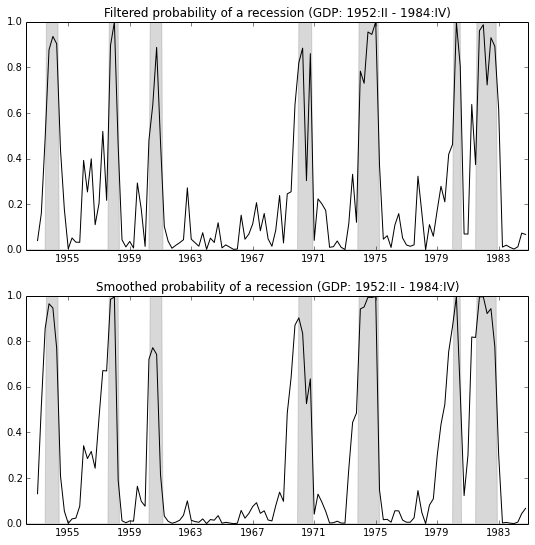

In [6]:
import matplotlib.pyplot as plt
from matplotlib import dates
fig = plt.figure(figsize=(9,9))

ax = fig.add_subplot(211)
ax.fill_between(usrec.index, 0, usrec.USREC, color='gray', alpha=0.3)
ax.plot(data.index, data.filtered, 'k')
ax.set(
    xlim=('1952-04-01', '1984-12-01'),
    ylim=(0,1),
    title='Filtered probability of a recession (GDP: 1952:II - 1984:IV)'
);

ax = fig.add_subplot(212)
ax.fill_between(usrec.index, 0, usrec.USREC, color='gray', alpha=0.3)
ax.plot(data.index, data.smoothed, 'k')
ax.set(
    xlim=('1952-04-01', '1984-12-01'),
    ylim=(0,1),
    title='Smoothed probability of a recession (GDP: 1952:II - 1984:IV)'
);